In [24]:
from hiererchical_simulator import *

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from numba import njit, prange
from multiprocessing import Pool
from multiprocessing import Process, Manager,cpu_count

@njit(parallel=True, fastmath=True, nopython=True)
def CME_numba(X):

    # _, gene_num = X.shape
    gene_num, _ = X.shape
    min_result = np.zeros((gene_num, gene_num), dtype=np.int64)
    (i_ind, j_ind) = np.triu_indices(gene_num)

    for k in prange(len(i_ind)):
        i = i_ind[k]
        j = j_ind[k]
        min_ary = np.minimum(X[i,:], X[j,:])
        min_result[j,i] = min_result[i,j] = sum(min_ary)      

    return min_result  

def CME(X):

    min_res = CME_numba(X)
    
    sum_x = np.sum(X, axis=1)
    ratio_x = min_res / sum_x[:, None]
    ratio_y = min_res / sum_x[None, :]
    result = 1 - np.maximum(ratio_x, ratio_y)

    return result.T

/home/chengwang/anaconda3/envs/Tamer/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
def generate_data(xml_file='tree_10.xml', mu=10, sigma=0.3):
    """
    使用 Dirichlet-Multinomial 分布生成模拟单细胞表达数据。
    
    流程说明：
    1. 从 XML 文件解析细胞类型树。
    2. 根据树结构生成 Dirichlet 分布的 alpha 矩阵。
    3. 从 Dirichlet 分布中采样每个细胞类型的比例 (p)。
    4. 根据采样的比例生成单细胞表达谱。
    5. 从对数正态分布中采样每个细胞的总 UMI 数量。
    6. 使用 Multinomial 分布生成最终的整数计数矩阵。
    7. 将模拟矩阵保存为 CSV 文件。

    参数
    ----
    xml_file : str, 可选
        定义细胞类型树的 XML 文件路径（默认 'tree_10.xml'）。
    mu : float, 可选
        对数正态分布的均值，用于模拟每个细胞的总 UMI（默认 10）。
    sigma : float, 可选
        对数正态分布的标准差，用于模拟每个细胞的总 UMI（默认 0.3）。

    返回
    ----
    pd.DataFrame
        模拟生成的单细胞表达矩阵（行为细胞，列为基因）。
    
    注意事项
    ----
    - 每个细胞类型的细胞数量由树的叶子节点确定。
    - alpha 矩阵控制每个细胞类型的 Dirichlet 分布，影响基因表达比例。
    - 每个细胞的总 UMI 独立从 log-normal 分布采样。
    - Multinomial 分布生成整数计数，保证总 UMI 与采样一致。
    - 输出文件保存路径为 './sim_data/csvs/'，文件名根据 XML 文件名生成。
    """
    
    # 根据xml生成树
    print("Parsing xml tree file...")
    root = parse_tree_from_xml(xml_file)
    # 生成alpha矩阵
    print("Generating alpha matrix...")
    alpha_matrix = generate_cell_gene_matrix(root)
    
    # 生成 Dirichlet的 p
    # 设定每个细胞类型的细胞数量（从树的叶子节点获取）
    print("Sampling p's from Dirichlet distribution...")
    cell_counts = {f'ctype_{leaf.name}': leaf.val for leaf in get_leaf_nodes(root)}
    
    # 生成单细胞表达谱
    expression_matrix, cell_types = generate_cell_expressions(alpha_matrix, cell_counts)
    
    # 生成logNormal总 UMI
    print("Sampling cell total UMIs from logNormal distribution...")
    total_expressions = []
    for leaf in get_leaf_nodes(root):
        n_cells = leaf.val
        mean = getattr(leaf, "mean", mu)
        sigma = getattr(leaf, "sigma", sigma)
        
        leaf_expressions = np.random.lognormal(mean=mean, sigma=sigma, size=n_cells)
        total_expressions.extend(leaf_expressions)

    total_expressions = np.array(total_expressions)

    
    # Multinomial生成最终矩阵
    print("Sampling cells from multinomial distribution...")
    final_matrix = generate_final_counts(expression_matrix, total_expressions)
    
    return pd.DataFrame(final_matrix)

In [3]:
def dropout(n_genes, adata):
    n_cells = adata.shape[0]

    data_matrix = np.zeros((n_cells, n_genes), dtype=np.float32)

    for gene_idx in range(n_genes):
        expression_counts = np.random.randint(1, 101, size=n_genes)
        cell_indices = [np.random.choice(n_cells, size=x, replace=False) for x in expression_counts]
        expression_values = [np.random.uniform(low=0.1, high=1.0, size=x) for x in expression_counts]
        data_matrix[cell_indices[gene_idx], gene_idx] = expression_values[gene_idx]

    gene_names = [f"gDrop_{i}" for i in range(n_genes)]
    cell_names = adata.obs_names

    # 创建 AnnData 对象
    adata_drop = ad.AnnData(
        X=data_matrix,
        var=pd.DataFrame(index=gene_names),
        obs=pd.DataFrame(index=cell_names)
    )
    merged_adata = ad.concat(
        [adata_drop, adata],
        axis=1,          
        join="outer",    
        merge="unique"   
    )
    return merged_adata


In [4]:
def get_data_and_visualize(tree_id, mu=10, sigma=0.3, 
                           tree_dir='./sim_data/trees', 
                           data_dir='./sim_data/adata'):
    """
    生成模拟单细胞表达数据，并绘制基因表达热图，同时保存 AnnData 对象。
    
    流程说明：
    1. 根据指定的 tree_id 从 XML 文件生成模拟单细胞数据（调用 generate_data）。
    2. 提取基因类别（gene category），用于热图列颜色映射。
    3. 提取细胞类型（cell type），用于热图行颜色映射。
    4. 为基因类别和细胞类型分配调色板。
    5. 绘制不聚类的单细胞表达热图（行为细胞，列为基因）。
    6. 在热图右侧添加细胞类型和基因类别图例。
    7. 将表达矩阵封装为 AnnData 对象，并保存为 h5ad 文件。
    
    参数
    ----
    tree_id : int
        树的编号，对应 XML 文件 tree_{tree_id}.xml。
    mu : float, 可选
        log-normal 分布的均值，用于模拟每个细胞总 UMI（默认 10）。
    sigma : float, 可选
        log-normal 分布的标准差，用于模拟每个细胞总 UMI（默认 0.3）。
    tree_dir : str, 可选
        存放 XML 树文件的目录（默认 './sim_data/trees'）。
    data_dir : str, 可选
        存放生成的 AnnData 对象的目录（默认 './sim_data/adata'）。
    
    返回
    ----
    data_df : pd.DataFrame
        模拟生成的单细胞表达矩阵（行为细胞，列为基因）。
    adata : AnnData
        对应的 AnnData 对象，包含表达矩阵和细胞类型信息 obs。
    
    注意事项
    ----
    - 生成的细胞名称格式为 "ctype_{cell_type}_cell{number}"。
    - 生成的基因名称以 "g{类别}_" 开头，如 "gA1_gene1"。
    - 热图行和列不进行聚类，仅用于可视化表达模式。
    """
    
    # 1. 生成模拟数据
    tree_file = f"{tree_dir}/tree_{tree_id}.xml"
    data_df = generate_data(tree_file, mu, sigma)

    # 2. 提取基因类别
    def extract_gene_category(gene_name):
        match = re.match(r'g(\w+)_', gene_name)
        if match:
            return match.group(1)
        return "Unknown"

    gene_categories = [extract_gene_category(gene) for gene in data_df.columns]
    gene_category_series = pd.Series(gene_categories, index=data_df.columns)

    # 3. 提取细胞类型
    def extract_cell_type(cell_name):
        match = re.match(r'ctype_(\w+)_cell\d+', cell_name)
        if match:
            return match.group(1)
        return None
    
    cell_types = [extract_cell_type(cell) for cell in data_df.index]
    if None in cell_types:
        raise ValueError("无法正确提取所有细胞类型，请检查索引格式")

    cell_type_series = pd.Series(cell_types, index=data_df.index)

    # 4. 分配颜色
    # 细胞类型颜色映射
    unique_cell_types = cell_type_series.unique()
    palette_cells = sns.color_palette("tab20", len(unique_cell_types))
    cell_type_colors = dict(zip(unique_cell_types, palette_cells))
    row_colors = cell_type_series.map(cell_type_colors)

    # 基因类别颜色映射
    unique_gene_categories = gene_category_series.unique()
    palette_genes = sns.color_palette("Set2", len(unique_gene_categories))
    gene_category_colors = dict(zip(unique_gene_categories, palette_genes))
    col_colors = gene_category_series.map(gene_category_colors)

    # 5. 绘制单细胞表达热图（不聚类）
    g = sns.clustermap(
        data_df,
        row_cluster=False,
        col_cluster=False,
        row_colors=row_colors,
        col_colors=col_colors,
        xticklabels=False,
        yticklabels=False,
        cbar_kws={'label': 'Expression'},
        figsize=(12, 8)
    )

    g.ax_heatmap.set_xlabel('Genes')
    g.ax_heatmap.set_ylabel('Cells')
    g.ax_heatmap.set_title("Gene Expression Heatmap")

    # 6. 添加图例
    # cell type legend
    handles_cell = [plt.Line2D([0], [0], marker='s', color=color, linestyle='') 
                    for color in cell_type_colors.values()]
    labels_cell = list(cell_type_colors.keys())

    # gene category legend
    handles_gene = [plt.Line2D([0], [0], marker='s', color=color, linestyle='') 
                    for color in gene_category_colors.values()]
    labels_gene = list(gene_category_colors.keys())

    # 在热图右侧添加两个 legend
    legend1 = g.ax_heatmap.legend(handles_cell, labels_cell, 
                                title="Cell Types", 
                                loc="upper left", bbox_to_anchor=(1.03, 1), 
                                borderaxespad=0)
    g.ax_heatmap.add_artist(legend1)  # 先画 cell types legend
    g.ax_heatmap.legend(handles_gene, labels_gene, 
                        title="Gene Categories", 
                        loc="lower left", bbox_to_anchor=(1.03, 0), 
                        borderaxespad=0)

    plt.show()

    # 7. 构建 AnnData 对象
    adata = sc.AnnData(X=data_df.values, 
                    obs=pd.DataFrame(index=data_df.index), 
                    var=pd.DataFrame(index=data_df.columns))

    # 添加细胞类型信息到 obs
    adata.obs['cell_type'] = [extract_cell_type(cell) for cell in adata.obs.index]

    # 保存 AnnData 对象
    print("Saving anndata to:", f"{data_dir}/adata_{tree_id}.h5ad")
    adata.write_h5ad(f"{data_dir}/adata_{tree_id}.h5ad")

    return data_df, adata

Parsing xml tree file...
Generating alpha matrix...
Sampling p's from Dirichlet distribution...
Sampling cell total UMIs from logNormal distribution...
Sampling cells from multinomial distribution...


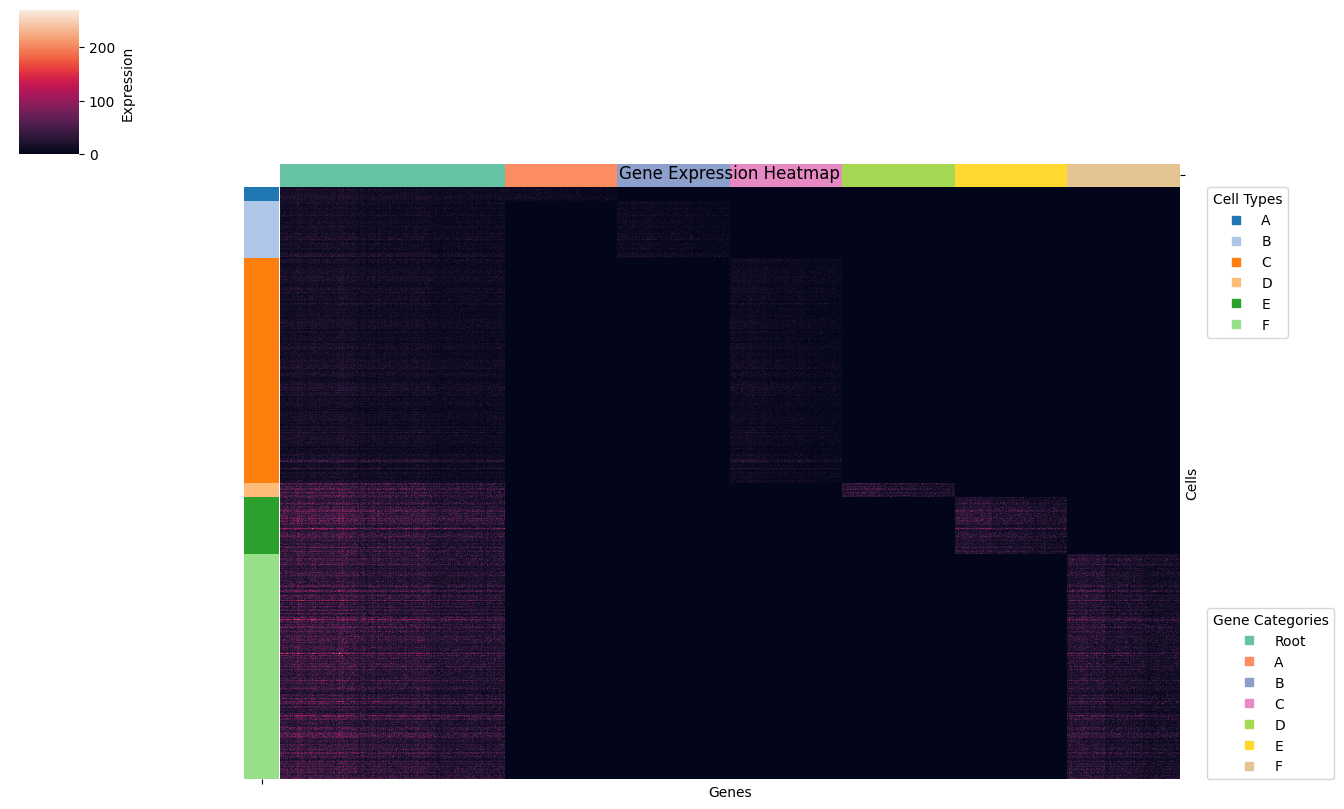

Saving anndata to: ./sim_data/adata/adata_13.h5ad


In [37]:
data_df, adata = get_data_and_visualize(tree_id=13)

In [6]:
adata = dropout(500, adata)

In [11]:
sc.pp.normalize_total(adata)

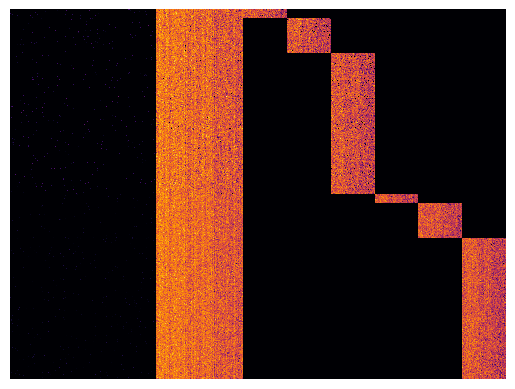

In [12]:
sns.heatmap(
    # np.log(adata_me.X+1),
    np.log(adata.X+1),
    cmap="inferno",
    xticklabels=False, yticklabels=False,
    cbar=False
)


plt.show()


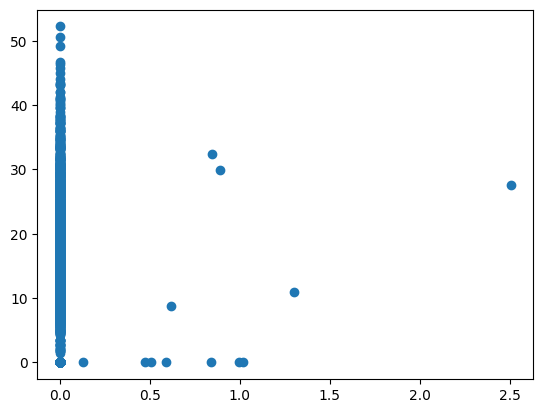

In [17]:
plt.scatter(adata.X[:,0], adata.X[:,1101])

In [31]:
cme_res = CME(adata.X.T)

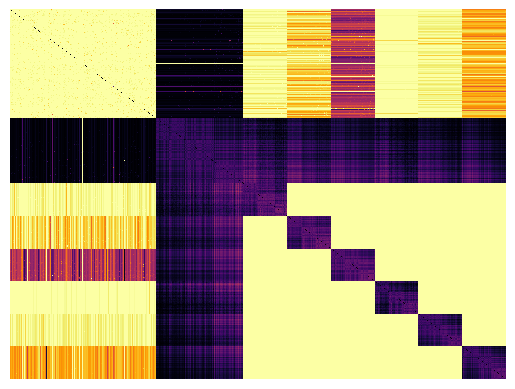

In [32]:
sns.heatmap(
    # np.log(adata_me.X+1),
    cme_res,
    cmap="inferno",
    xticklabels=False, yticklabels=False,
    cbar=False
)


plt.show()


In [35]:
cme_res[0,1]

1.0

In [33]:
cme_res[0,501]

0.0668215693060572

In [ ]:
plt.scatter(adata.X[:,0], adata.X[:,801])

In [36]:
adata.write("sim_data/adata/mule_sim.h5ad")